# The Principles of DNA Sequence Compression

First let's import everything we need:

In [40]:
import gzip
import math
import matplotlib.pyplot as plt
import random

import alignment
import entropy

## Quantification of Information

Information theory is based on the observation that knowing that a likely event has occurred is less informative than knowing that an unlikely event has occurred.

A quantification of information should have the following properties:

- Likely events should have a low information content, and events that are certain to occur should have no information content at all. Less likely events should have a higher information content.
- Independent events should have additive information content.

The self-information of an event $x$ is hence defined as

$$I(x)=-\log{}P(x).$$

By using the base-2 logarithm, the unit of self-information is bit. Hence, one bit is the amount of information gained by observing an event of probability $\frac{1}{2}$.

Self-information deals only with a single event $x$. By computing the expectation of the self-information with respect to the entire probability distribution $P(\text{x})$ we obtain the entropy

$$H(\text{x})=\mathbb{E}_{\text{x}\sim{}P}[I(x)]=-\mathbb{E}_{\text{x}\sim{}P}[\log{}P(x)]=-\sum_{x}P(x)\log{}P(x).$$

The entropy gives the average information that is expected in an event $x$ drawn from probability distribution $P(\text{x})$.

**Experiment** &mdash; Compute the entropy of the sequences `AAAA`, `AACC`, `ACGT`.

In [41]:
for s in ['AAAA', 'AACC', 'ACGT']:
    eta = entropy.entropy(s)
    print("Entropy of '{}': {:.2f} bit/symbol".format(s, round(eta, 2)))

Entropy of 'AAAA': 0.00 bit/symbol
Entropy of 'AACC': 1.00 bit/symbol
Entropy of 'ACGT': 2.00 bit/symbol


## Na&iuml;ve Compression of DNA Sequence Reads

The FASTQ format is the de-facto standard for the storage of reads, i.e., nucleotide sequences, including corresponding quality scores.

Each read is represented by a single FASTQ record, which consists of four lines:
- The first line contains the read identifier. It starts with `@`. Typically, sequencing machine vendors generate read identifiers in a proprietary systematic way.
- The second line contains the nucleotide sequence, where each nucleotide is represented with a single ASCII character.
- The third line starts with `+` and contains an optional description. Usually this line is left empty; it then only contains `+` as separator between the nucleotide sequence and the quality scores.
- The fourth line contains the quality scores. A quality score is a value indicating the confidence in a base call.

We can convert a FASTQ record (four lines) into a dictionary with the following function:

In [42]:
def fastq_lines_to_dict(lines):
    keys = ['id', 'seq', 'desc', 'qual']
    return {key: value for key, value in zip(keys, lines)}

**Experiment** &mdash; Parse the FASTQ file `example.fastq`.

In [43]:
file_name = 'example.fastq'
records = []

with open(file_name, 'r') as f:
    lines = []
    for line in f:
        lines.append(line.rstrip())
        if (len(lines)) == 4:
            records.append(fastq_lines_to_dict(lines))
            lines = []

for i, r in enumerate(records):
    print('Record {}: {}'.format(i, str(r)))

Record 0: {'id': '@id0', 'seq': 'GATTTGGGGTTCAAAGCAGTATCGATCAAATA', 'desc': '+', 'qual': "!''*((((***+))%%%++)(%%%%).1***-"}
Record 1: {'id': '@id1', 'seq': 'GATTTGGGGTTCAAAGCAGTATCGATCAAATA', 'desc': '+', 'qual': "!''*((((***+))%%%++)(%%%%).1***-"}
Record 2: {'id': '@id2', 'seq': 'GATTTGGGGTTCAAAGCAGTATCGATCAAATA', 'desc': '+', 'qual': "!''*((((***+))%%%++)(%%%%).1***-"}
Record 3: {'id': '@id3', 'seq': 'GATTTGGGGTTCAAAGCAGTATCGATCAAATA', 'desc': '+', 'qual': "!''*((((***+))%%%++)(%%%%).1***-"}


**Experiment** &mdash; Concatenate all nucleotide sequences from the FASTQ file `example.fastq`. Compute the entropy and the maximum (worst-case) compressed size in bit and byte.

In [44]:
seq = ''
for r in records:
    seq += r['seq']
seq_len = len(seq)
print('Concatenated sequence length: {}'.format(seq_len))

eta = entropy.entropy(seq)
print("Entropy: {:.2f} bit/symbol".format(round(eta, 2)))

max_size_in_bit = math.ceil(eta * seq_len)
max_size_in_byte = math.ceil(max_size_in_bit / 8)

print('Maximum compressed size: {} bit = {} byte'.format(max_size_in_bit, max_size_in_byte))
print('Worst-case compression ratio: {:.1f}x'.format(seq_len / max_size_in_byte))

Concatenated sequence length: 128
Entropy: 1.92 bit/symbol
Maximum compressed size: 246 bit = 31 byte
Worst-case compression ratio: 4.1x


**Experiment** &mdash; Use gzip to beat the estimated worst-case compression.

In [45]:
amplification_factor = 10

seq = ''
for r in records:
    seq += r['seq']
seq = seq * amplification_factor
seq_len = len(seq)

compressed_seq = gzip.compress(data=bytes(seq, 'utf-8'))
decompressed_seq = gzip.decompress(data=compressed_seq).decode('utf-8')

if decompressed_seq != seq:
    raise RuntimeError('decompressed sequence is *not* equal to the original sequence')

max_size_in_byte = math.ceil((math.ceil(entropy.entropy(seq) * seq_len)) / 8)
    
print('Worst-case compression ratio: {:.1f}x'.format(seq_len / max_size_in_byte))
print('Gzip compression ratio: {:.1f}x'.format(seq_len / len(compressed_seq)))

Worst-case compression ratio: 4.2x
Gzip compression ratio: 22.9x


## Using Alignment to Improve Compression of DNA Sequence Reads

The Needleman-Wunsch algorithm finds the optimal *global* alignment (end-to-end) between two sequences. It consists of the following steps:

- Construct the grid
- Choose a scoring system (here we use the original scoring system assigning a score of 1 to a match and a score of -1 to a mismatch or indel/gap)
- Fill in the scoring matrix (and construct the pointer matrix on the way)
- Use the pointer matrix to perform a traceback to recover the optimal warping path

The scores are computed using the already existing scores in the left, top-left, and top cells:

$$
F(i,j)=\max\begin{cases}F(i-1,j-1)+s(x_i,y_i),\\F(i-1,j)-d,\\F(i,j-1)-d.\end{cases}
$$

The following image illustrates the scoring and pointer matrices.

![Needleman-Wunsch pairwise sequence alignment](needleman-wunsch_pairwise_sequence_alignment.png)

**Experiment** &mdash; Perform the global alignment between the sequences `GATTACA` and `CATACCCA`. Plot the scoring matrix and the warping path.

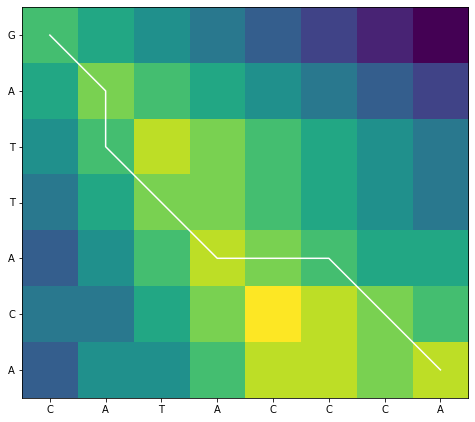

In [46]:
x = 'GATTACA'
y = 'CATACCCA'

x_aligned, y_aligned, path_x, path_y, F = alignment.align(x, y, mode='global')

%matplotlib inline
plt.figure(figsize=[8, 8])
plt.imshow(F)
plt.xticks(ticks=range(len(y)), labels=y)
plt.yticks(ticks=range(len(x)), labels=x)
plt.plot(path_y, path_x, 'w')
plt.show()

The Smith-Waterman algorithm finds the optimal *local* alignment between two sequences. It is a variation of the Needleman-Wunsch algorithm. The three main differences are:

|                | Smith-Waterman algorithm                                | Needleman-Wunsch algorithm                                                 |
|----------------|---------------------------------------------------------|----------------------------------------------------------------------------|
| Initialization | First row/column = 0                                    | First row/column subject to gap penalty                                    |
| Scoring        | Negative scores are set to 0                            | Scores can be negative                                                     |
| Traceback      | Begin with the highest score, end when 0 is encountered | Begin with the cell at the lower right of the matrix, end at top left cell |

**Experiment** &mdash; Perform the local alignment between the sequences `GATACCA` and `NNNNNNNNNNGATTACANNNNNNNNGATNNNNNNNNN`. Plot the scoring matrix and the warping path.

alignment.align: multiple (2) possible traceback starts, choosing [ 7 17]


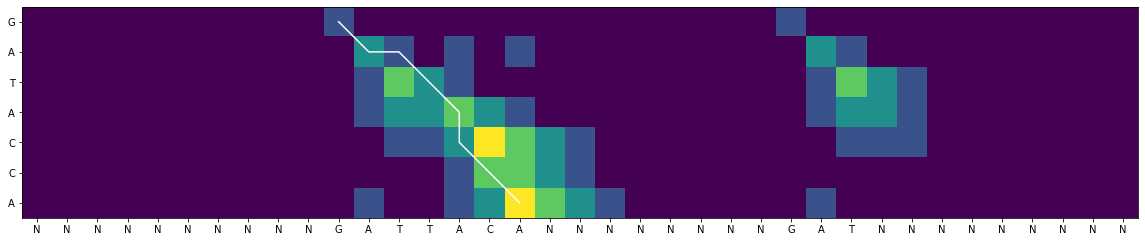

In [47]:
x = 'GATACCA'
y = 'NNNNNNNNNNGATTACANNNNNNNNGATNNNNNNNNN'

x_aligned, y_aligned, path_x, path_y, F = alignment.align(x, y, mode='local')

%matplotlib inline
plt.figure(figsize=[20, 10])
plt.imshow(F)
plt.xticks(ticks=range(len(y)), labels=y)
plt.yticks(ticks=range(len(x)), labels=x)
plt.plot(path_y, path_x, 'w')
plt.show()

The compression of reads can be improved by aligning them to a known reference sequence.

**Experiment** &mdash; Sample 10 reads from the reference sequence `GATTTGGGGTTCAAAGCAGTATCGATCAAATAGTAAATCCATTTGTTCAACTCACAGTTTA`.

In [48]:
ref = 'GATTTGGGGTTCAAAGCAGTATCGATCAAATAGTAAATCCATTTGTTCAACTCACAGTTTA'

num_reads = 10
min_read_len = 5
max_read_len = 10

reads = []

for i in range(num_reads):
    start = 0
    end = 0
    range_acquired = False
    while not range_acquired:
        start = random.randrange(len(ref))
        end = random.randrange(len(ref))
        if start > end:
            continue
        range_len = end - start + 1
        if range_len < min_read_len:
            continue
        if range_len > max_read_len:
            continue
        range_acquired = True
    read = ref[start:(end + 1)]
    reads.append(read)
    print('Read {}: {} '.format(i, read))

Read 0: GGGGT 
Read 1: AATCCATTTG 
Read 2: TCAAAGCAGT 
Read 3: AATAGTAAAT 
Read 4: GCAGTATCG 
Read 5: TTGTTCAAC 
Read 6: ATTTG 
Read 7: GGGGTTC 
Read 8: TCAACTCACA 
Read 9: AAGCAGTATC 


**Experiment** &mdash; Add some noise to the sampled reads.

In [49]:
def add_noise(read, abundance=4):
    choices = ['A', 'C', 'G', 'T']
    num_noisy_bases = 0
    noisy_read = ''
    for base in read:
        if not random.randrange(abundance):
            noisy_read += random.choice([c for c in choices if c != base])
            num_noisy_bases += 1
        else:
            noisy_read += base
    return noisy_read, num_noisy_bases

noisy_reads = []
for r in reads:
    noisy_read, num_noisy_bases = add_noise(read=r, abundance=4)
    print('Added {} noisy base(s): {:10s} -> {:10s}'.format(num_noisy_bases, r, noisy_read))
    noisy_reads.append(noisy_read)

Added 2 noisy base(s): GGGGT      -> GTCGT     
Added 3 noisy base(s): AATCCATTTG -> AGCCCATTTA
Added 1 noisy base(s): TCAAAGCAGT -> TCCAAGCAGT
Added 2 noisy base(s): AATAGTAAAT -> AAAAGCAAAT
Added 0 noisy base(s): GCAGTATCG  -> GCAGTATCG 
Added 3 noisy base(s): TTGTTCAAC  -> ATGTTAATC 
Added 1 noisy base(s): ATTTG      -> ATTGG     
Added 1 noisy base(s): GGGGTTC    -> GAGGTTC   
Added 4 noisy base(s): TCAACTCACA -> TGATGTCATA
Added 1 noisy base(s): AAGCAGTATC -> AAGCAGTTTC


**Experiment** &mdash; Align the noisy reads locally to the reference sequence. Compute the residual of each noisy read w.r.t. the reference sequence.

alignment.align: multiple (2) possible traceback starts, choosing [ 4 24]
Noisy read            : GTCGT
Reference subsequence : TCG
Aligned read          : TCG (2 base(s) clipped from the alignment)
Residual              : mmm


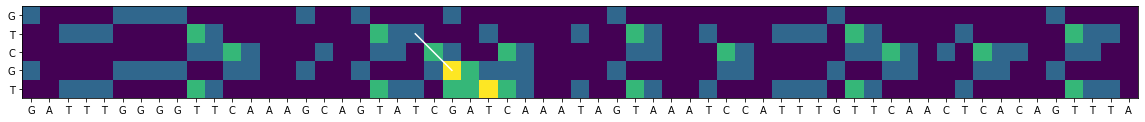

Noisy read            : AGCCCATTTA
Reference subsequence : CCATTT
Aligned read          : CCATTT (4 base(s) clipped from the alignment)
Residual              : mmmmmm


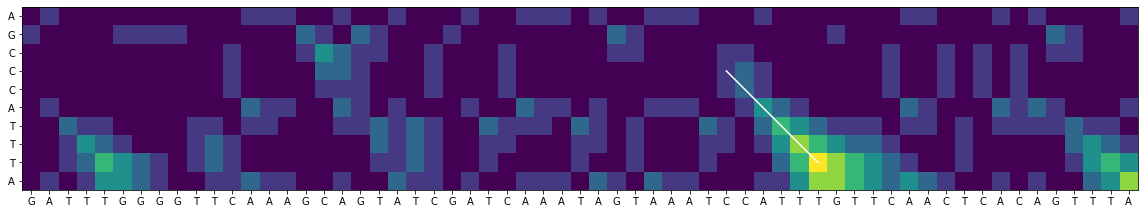

Noisy read            : TCCAAGCAGT
Reference subsequence : TCAAAGCAGT
Aligned read          : TCCAAGCAGT (0 base(s) clipped from the alignment)
Residual              : mmCmmmmmmm


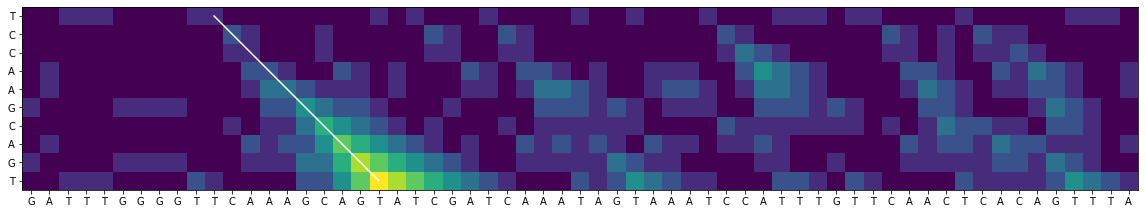

Noisy read            : AAAAGCAAAT
Reference subsequence : AAATAGTAAAT
Aligned read          : AAA-AGCAAAT (0 base(s) clipped from the alignment)
Residual              : mmm-mmCmmmm


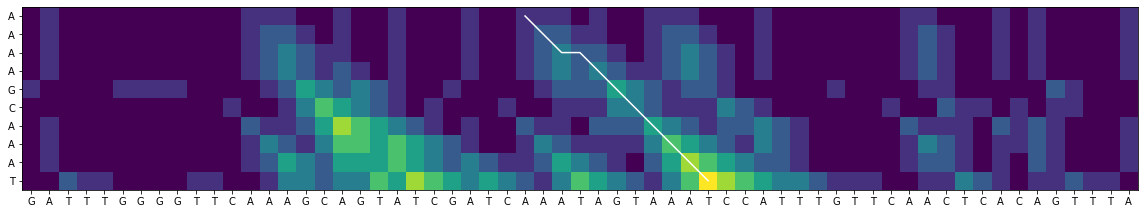

Noisy read            : GCAGTATCG
Reference subsequence : GCAGTATCG
Aligned read          : GCAGTATCG (0 base(s) clipped from the alignment)
Residual              : mmmmmmmmm


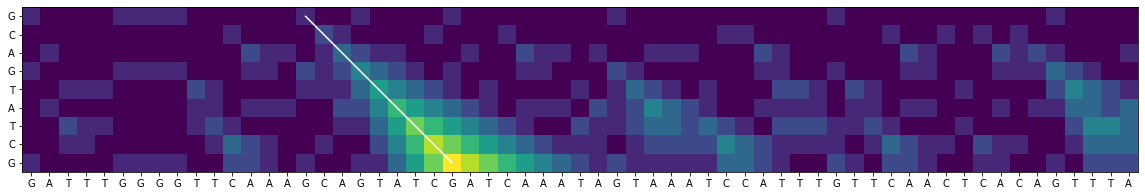

alignment.align: multiple (2) possible traceback starts, choosing [ 9 39]
Noisy read            : ATGTTAATC
Reference subsequence : ATAGTAAATC
Aligned read          : AT-GTTAATC (0 base(s) clipped from the alignment)
Residual              : mm-mmTmmmm


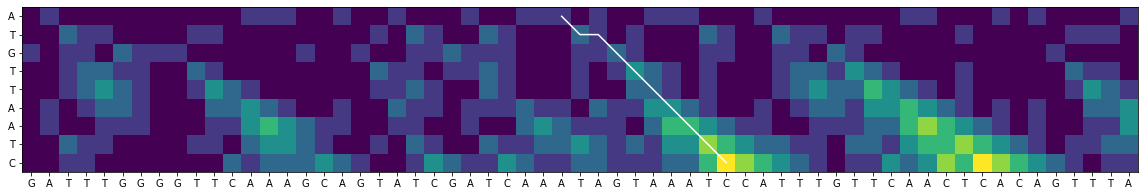

Noisy read            : ATTGG
Reference subsequence : TTGG
Aligned read          : TTGG (1 base(s) clipped from the alignment)
Residual              : mmmm


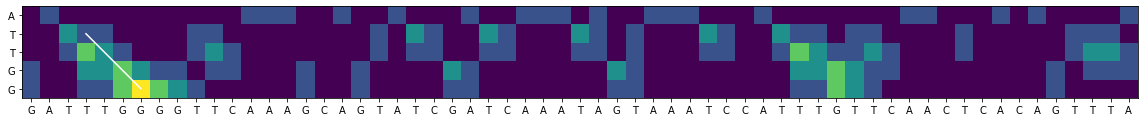

Noisy read            : GAGGTTC
Reference subsequence : GGTTC
Aligned read          : GGTTC (2 base(s) clipped from the alignment)
Residual              : mmmmm


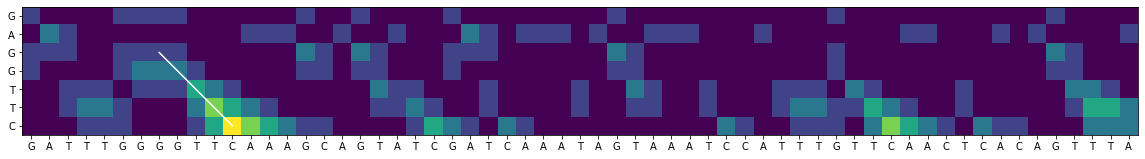

alignment.align: multiple (6) possible traceback starts, choosing [10 30]
Noisy read            : TGATGTCATA
Reference subsequence : ATCGATCAAA
Aligned read          : AT-G-TCATA (2 base(s) clipped from the alignment)
Residual              : mm-m-mmmTm


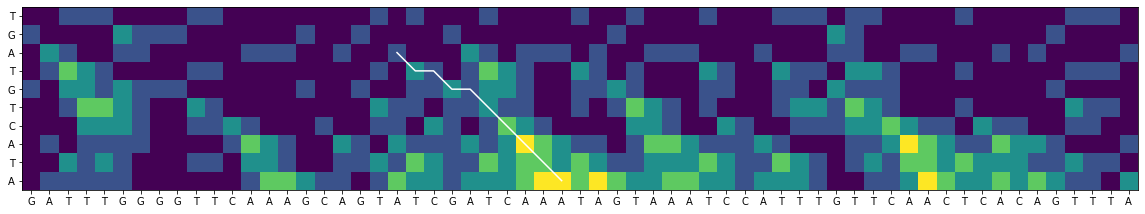

Noisy read            : AAGCAGTTTC
Reference subsequence : AAGCAGTATC
Aligned read          : AAGCAGTTTC (0 base(s) clipped from the alignment)
Residual              : mmmmmmmTmm


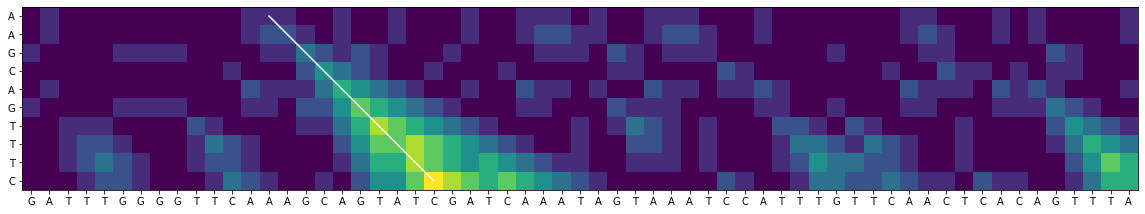

In total, 11 bases were clipped


In [50]:
residuals = []
total_num_clipped_bases = 0

for r in noisy_reads:
    read_aligned, ref_aligned, path_x, path_y, F = alignment.align(x=r, y=ref, mode='local')

    read_aligned_without_gaps = read_aligned.replace('-', '')
    num_clipped_bases = len(r) - len(read_aligned_without_gaps)
    total_num_clipped_bases += num_clipped_bases
    
    ref_subsequence = ref[path_y[0]:(path_y[-1] + 1)]
    residual = ''
    for i in range(len(read_aligned)):
        if i >= len(ref_subsequence) or read_aligned[i] != ref_subsequence[i]:
            residual += read_aligned[i]
        else:
            residual += 'm'
    residuals.append(residual)
    
    print('Noisy read            : {}'.format(r))
    print('Reference subsequence : {}'.format(ref_subsequence))
    print('Aligned read          : {} ({} base(s) clipped from the alignment)'.format(read_aligned, num_clipped_bases))
    print('Residual              : {}'.format(residual))
    
    %matplotlib inline
    plt.figure(figsize=[20,10])
    plt.imshow(F)
    plt.xticks(ticks=range(len(ref)), labels=ref)
    plt.yticks(ticks=range(len(r)), labels=r)
    plt.plot(path_y, path_x, 'w')
    plt.show()
    
print('In total, {} bases were clipped'.format(total_num_clipped_bases))

**Experiment** &mdash; Calculate the entropy of the noisy reads and of the residual (plus an estimate for the clipped bases).

In [51]:
noisy_reads = ''.join(noisy_reads)
noisy_reads_eta = entropy.entropy(noisy_reads)
print('Entropy (noisy reads): {:.2f} bit/symbol'.format(round(noisy_reads_eta, 2)))

noisy_reads_max_size_in_bit = math.ceil(noisy_reads_eta * len(noisy_reads))
noisy_reads_max_size_in_byte = math.ceil(noisy_reads_max_size_in_bit / 8)
print('Maximum compressed size (noisy reads): {} bit = {} byte'.format(
    noisy_reads_max_size_in_bit, noisy_reads_max_size_in_byte))
           
residuals = ''.join(residuals)
residuals_eta = entropy.entropy(residuals)
print('Entropy (residuals): {:.2f} bit/symbol'.format(round(residuals_eta, 2)))

residuals_max_size_in_bit = math.ceil(residuals_eta * len(residuals))
clips_max_size_in_bit = total_num_clipped_bases * 2
aligned_reads_max_size_in_bit = residuals_max_size_in_bit + clips_max_size_in_bit
aligned_reads_max_size_in_byte = math.ceil((aligned_reads_max_size_in_bit) / 8)

print('Maximum compressed size (residuals + clipped bases): {} + {} bit = {} bit = {} byte'.format(
    residuals_max_size_in_bit, clips_max_size_in_bit, aligned_reads_max_size_in_bit, aligned_reads_max_size_in_byte))

print('Theoretical gain achieved by alignment: {:.2f}%'.format(
    100 * ((noisy_reads_max_size_in_byte - aligned_reads_max_size_in_byte) / noisy_reads_max_size_in_byte)))

Entropy (noisy reads): 1.97 bit/symbol
Maximum compressed size (noisy reads): 168 bit = 21 byte
Entropy (residuals): 0.69 bit/symbol
Maximum compressed size (residuals + clipped bases): 55 + 22 bit = 77 bit = 10 byte
Theoretical gain achieved by alignment: 52.38%
